In [1]:
SAMPLERATE = 44100 # Hz
SAMPLES = 2**14
FREQ = 1000 # Hz
AMPLITUDE = 0.5

DURATION = SAMPLES / SAMPLERATE
print("simulation duration: {:.2f}s".format(DURATION))

simulation duration: 0.37s


In [2]:
import numpy as np
from numba import jit
from util.plot_utils import *
init_plot(DURATION, FREQ, SAMPLERATE)

generate the input data

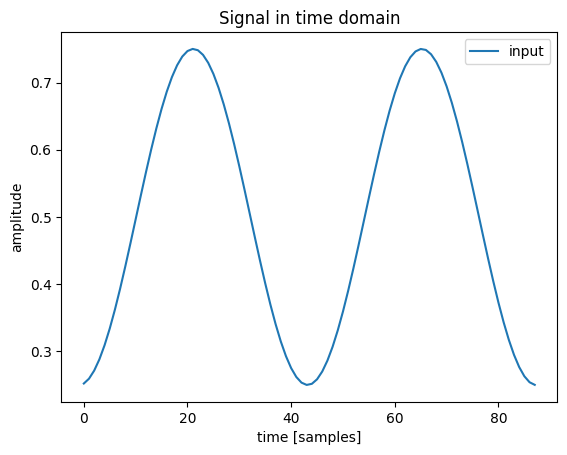

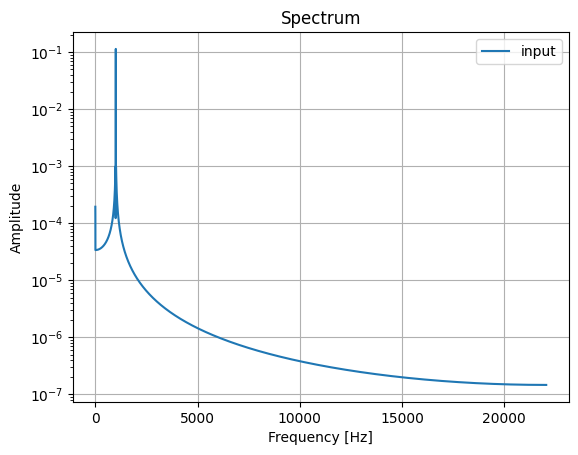

In [3]:
t = np.linspace(0, DURATION, SAMPLES)
sin = np.sin(t * 2 * np.pi * FREQ) * AMPLITUDE
input_samples = (sin + 1) / 2
plot_signals(input=input_samples)

next, we pass the input through a modulator

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


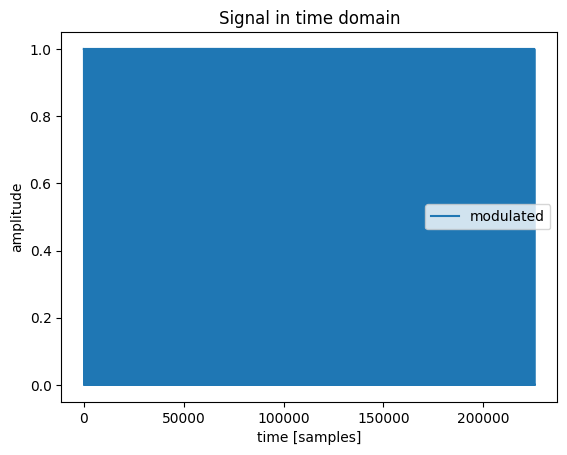

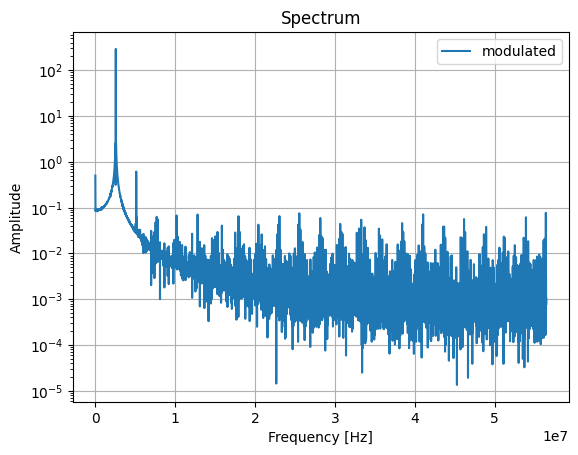

In [4]:
from scipy.signal import resample

def modulate_pwm(input, *, n_bits, oversampling_ratio):
    resampled = resample(input, len(input) * oversampling_ratio)
    
    quantized_samples = np.array(np.round(resampled * 2**n_bits), dtype=int)
    
    @jit(nopython=True, parallel=True)
    def loop():
        output = np.zeros(len(resampled) * 2**n_bits)
        for i, sample in enumerate(quantized_samples):
            for j in range(sample):
                output[(i * 2**n_bits) + j] = True
        return output
    return loop()

modulated = modulate_pwm(input_samples, n_bits=8, oversampling_ratio=10)
plot_signals(modulated=modulated)

In [5]:
oversampled_rate = len(modulated) / DURATION
print("oversampled rate is {:.2f}Mhz. oversampling factor is {}".format((oversampled_rate / 10e6), oversampled_rate // SAMPLERATE))

changes = np.sum(modulated[:-1] != modulated[1:]) / 2
switching_rate = changes / DURATION
print("average switching frequency is {:.2f}kHz".format(switching_rate / 1000))

oversampled rate is 11.29Mhz. oversampling factor is 2560.0
average switching frequency is 441.00kHz


now we downsample the signal again and do lowpass filtering
this step can be further tweaked and needs to reflect the parameters of the real hardware

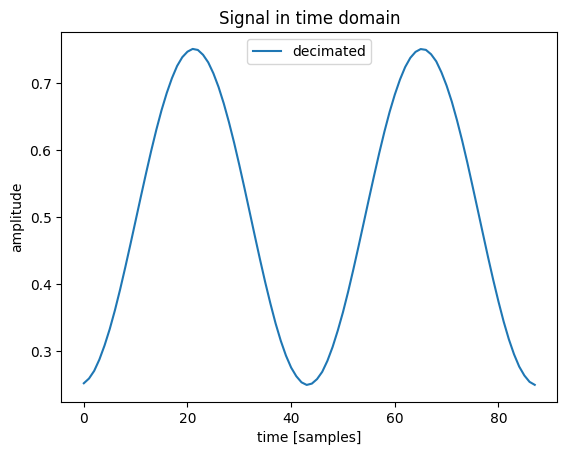

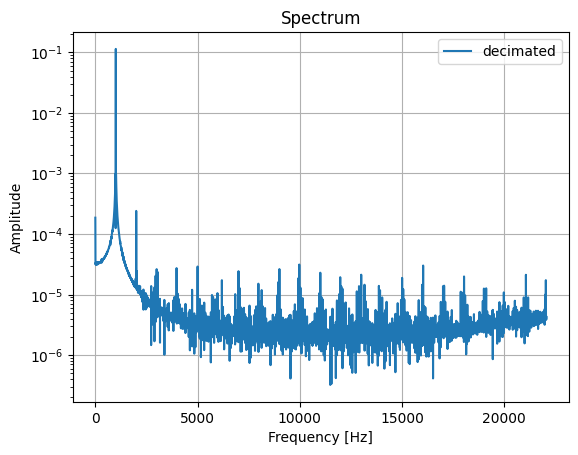

In [6]:
from scipy.signal import decimate
decimated = decimate(modulated, int(oversampled_rate / SAMPLERATE), ftype="fir")
plot_signals(decimated=decimated)

then we analyze the quality of the downsampled signal

phase shift is 0 samples (0.00ms)


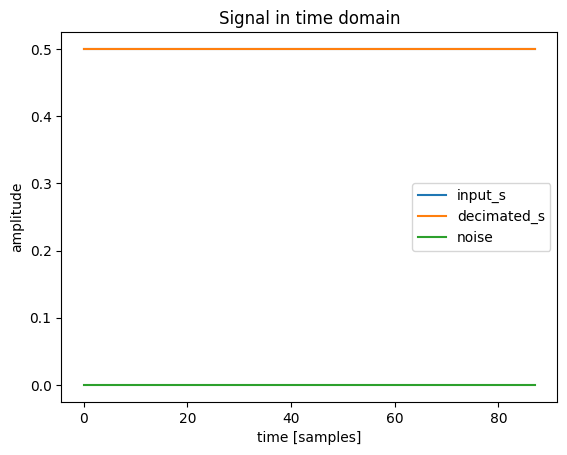

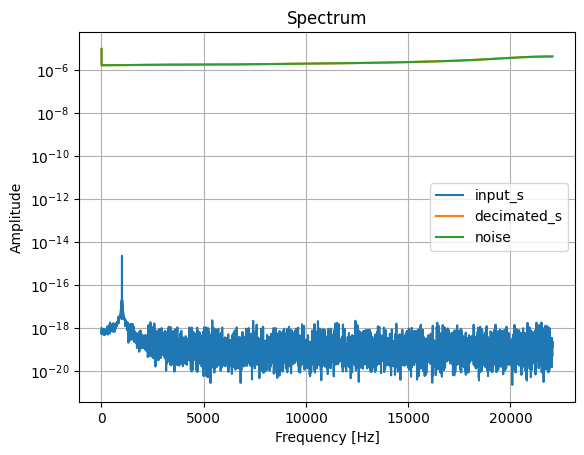

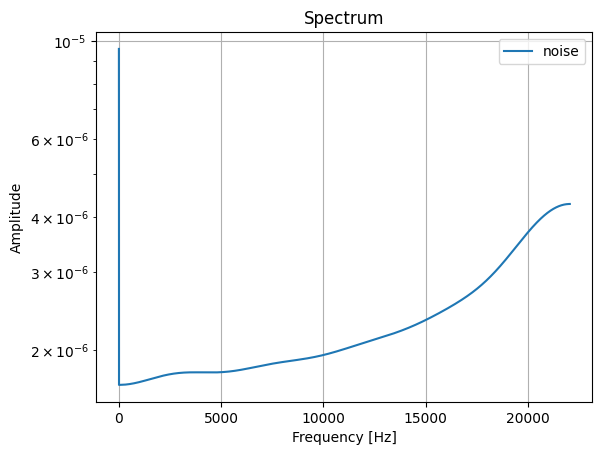

Noise Level: -49.84dB
SNR: 46.83dB


In [15]:
from scipy.signal import correlate

shift = 0 # np.argmax(correlate(input_samples, decimated)) % int((1 / FREQ) * SAMPLERATE)
print("phase shift is {} samples ({:.2f}ms)".format(shift, shift / SAMPLERATE * 1000))

decimated_s, input_s = decimated[:(-shift if shift != 0 else len(decimated))], input_samples[shift:]

noise = decimated_s - input_s

plot_signals(input_s=input_s, decimated_s=decimated_s, noise=noise)
plot_spectrum(noise=noise)
noise_level = np.abs(np.average(noise))
print("Noise Level: {:.2f}dB".format(np.log10(noise_level) * 10))
print("SNR: {:.2f}dB".format(np.log10(np.average(input_samples) / noise_level) * 10))